In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import regressionSummary, exhaustive_search, backward_elimination, forward_selection, stepwise_selection

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from math import log
from statistics import mean

import matplotlib as mpl
import matplotlib.pyplot as plt

from xmlrpc.client import boolean


In [2]:
# importing dataset file
ds= pd.read_csv("F:/Junkyard/Studies/Data Science and Machine Learning/session_4/project_proposals/datasets/dataset2_houseprice/house_price.csv")

ds.info()
#ds.describe()
#ds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
# Data Preparation: Groups of different data types
# extracting name of the columns (attributes) with differend data types

obj = (ds.dtypes == 'object')       # returns a dataframe that has column for index and corresponding
                                        # True/False statement for second column (if data in the column is object)
object_cols = list(obj[obj].index)  # obj[obj] returns rows with only True values and index method
                                        # return first column(name of the columns in original dataset)
print("Categorical feature:",len(object_cols))

#same for integers as for objects
int_ = (ds.dtypes == 'int64')
num_cols = list(int_[int_].index)
print("Integer features:",len(num_cols))

#same for floats as for objects
fl = (ds.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float features:",len(fl_cols))


Categorical feature: 43
Integer features: 35
Float features: 3


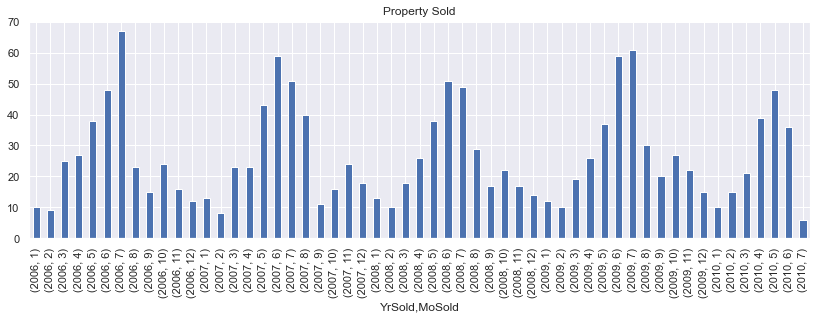

In [4]:
# Business understanding
# Interesting correlations in the categorical features
    # When was the property sold in which year and month

#%matplotlib inline
sns.set() 
ds.groupby(['YrSold','MoSold']).Id.count().plot(kind='bar',figsize=(14,4))
plt.title('Property Sold')
plt.show()


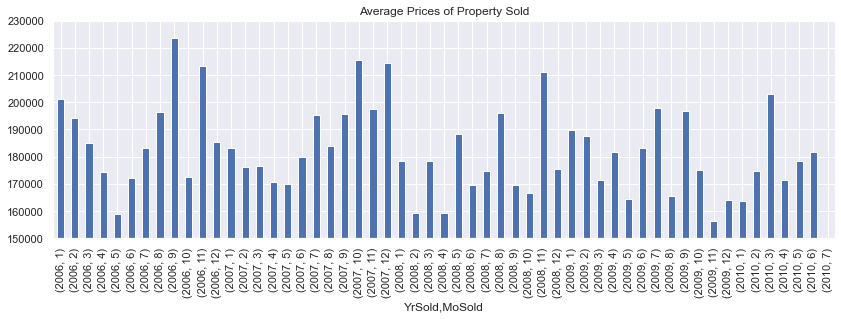

In [5]:
# Business understanding (the reducible/irreducible error in addition to average variability of house prices, the timeframe of dataset is
# in 2008 financial crysis)
# The stock market crash of 2008 occurred on September 29, 2008.
# Number of houses sold in a month relates to average houseprice in that months
# What effects of 2008 crysis are on display and what are not?
# (for example: some CEOs who went bankrupt selling their super expensive property to pay the debt)

%matplotlib inline
ds.groupby(['YrSold','MoSold']).SalePrice.mean().plot(kind='bar',figsize=(14,4))

plt.ylim(150000,230000)
plt.title('Average Prices of Property Sold')

plt.show()


<AxesSubplot:title={'center':'No. Unique values of Categorical Features'}>

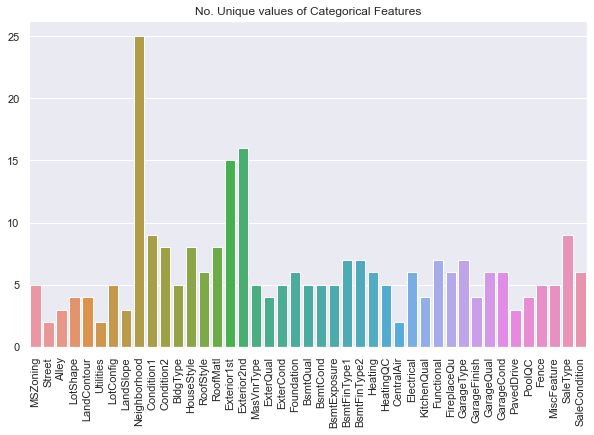

In [6]:
# Data Mining
# Since we have a ready-to work on data in initial dataframe we skip the 'gathering' step.
# As we discovered earlier, categorical features might present an issue in this dataframe, lets explore this issue a bit futher. 

# Code: extracts unique variables from columns and counts them
unique_values = []
for col in object_cols:
  unique_values.append(ds[col].unique().size)

plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)


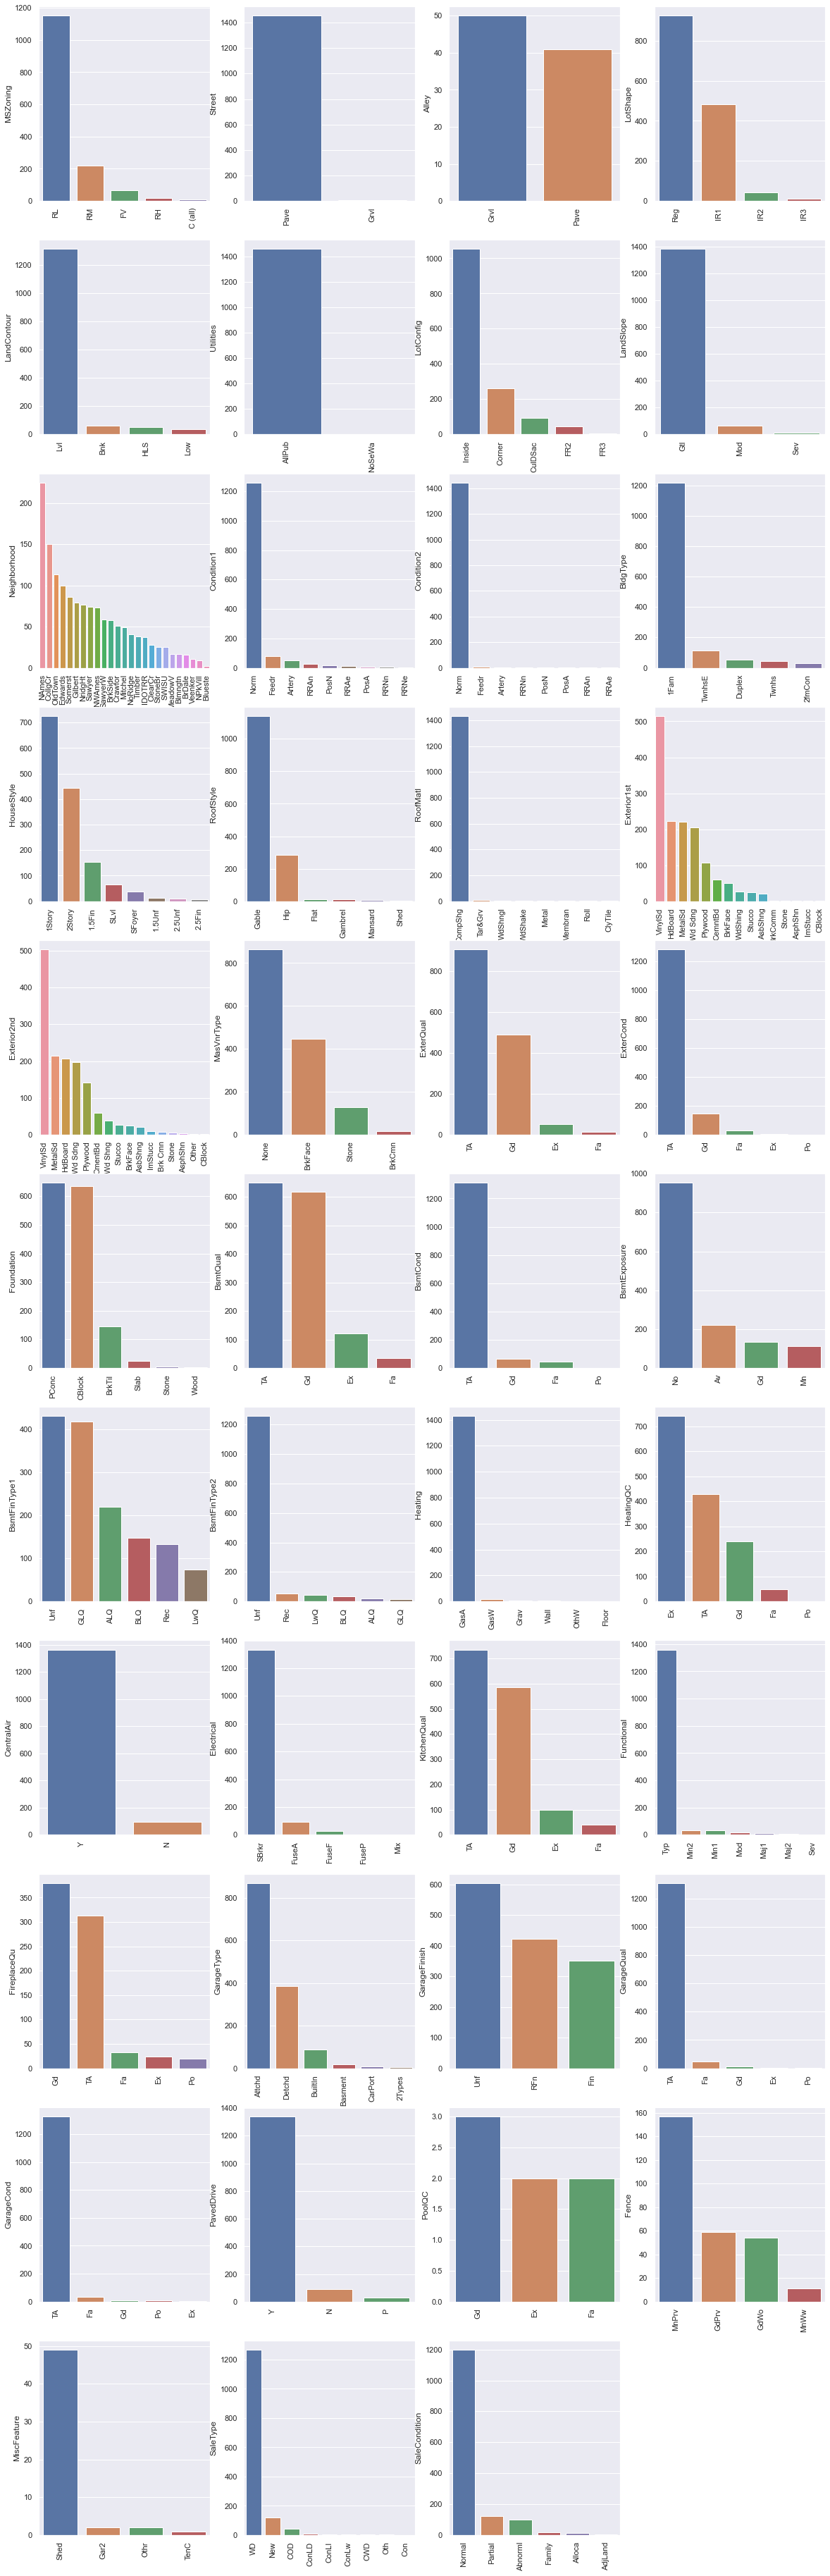

In [7]:
# Data mining
# In order to make any "mining" steps for cathegorical features, we first need to see how unique values are distributed in those columns

# Visualizing data 
# Unique value distribution in categorical features:

# creating an area for subplots
plt.figure(figsize=(20, 66))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
# creates subplot
i = 1
for col in object_cols:
    y = ds[col].value_counts()    #returns the dataset where 1st column are unique variables of
                                    # an attribute and 2nd is number of values each variable has
    plt.subplot(11, 4, i)    #size of subplot
    plt.xticks(rotation=90)         #rotate names of variables
    sns.barplot(x=list(y.index), y=y)   # x returns the index (original variable names)
    
    i += 1

In [8]:
# Data mining . 
# This plot helps us to discover alot of important information and build our strategy for Data Cleaning steps.
# From plot above: most features have dominant values and variety of values is low for majority of those features; 
# many of the values are nearly missing (very low presence), those values have an impact similar to outliers and they special treatment.
# As a rule, we don't drop features on the stage of Data mining (however, some of them deserve to be dropped)

# Our goal in data mining will be uniting 'similar' variables of a column. Eliminating values with low presence and lowering the number
# of values, in general will reduce the uncertanty for predictive models.
# To do that (unite values) we can use the description of a dataset (understanding of data) and value distribution plot, but 
# we would like to have one more reference, that somehow correlates to our target (SalePrice).
# That correlation would be are average saleprice for unique value of categorical data.

# Creating a dataframe, that shows the average SalePrice of each unique categorical variable:

ar=pd.DataFrame({'column':[],'variable':[],'mean price':[]})
cl=list()
for x in range(len(ds.columns)):
        col_name=ds.columns[x]
        column=ds[col_name]
        un_var=column.unique()
        if ds[col_name].dtypes==object:
                cl.append(col_name)
                for i in range(len(un_var)):
                        prices=ds.loc[column==un_var[i]]['SalePrice']
                        mp=prices.mean()
                        row=pd.DataFrame({'column':[col_name],'variable':[un_var[i]],'mean price':[mp]})
                        ar=pd.concat([ar,row],ignore_index=True,axis=0)
                        

ar=ar.sort_values(['column','mean price'],ascending=[1,1],ignore_index=True) # addition
print(ar)     #resulting dataset

        column variable     mean price
0        Alley     Grvl  122219.080000
1        Alley     Pave  168000.585366
2        Alley      NaN            NaN
3     BldgType   2fmCon  128432.258065
4     BldgType   Duplex  133541.076923
..         ...      ...            ...
263   SaleType      New  274945.418033
264     Street     Grvl  130190.500000
265     Street     Pave  181130.538514
266  Utilities   NoSeWa  137500.000000
267  Utilities   AllPub  180950.956820

[268 rows x 3 columns]


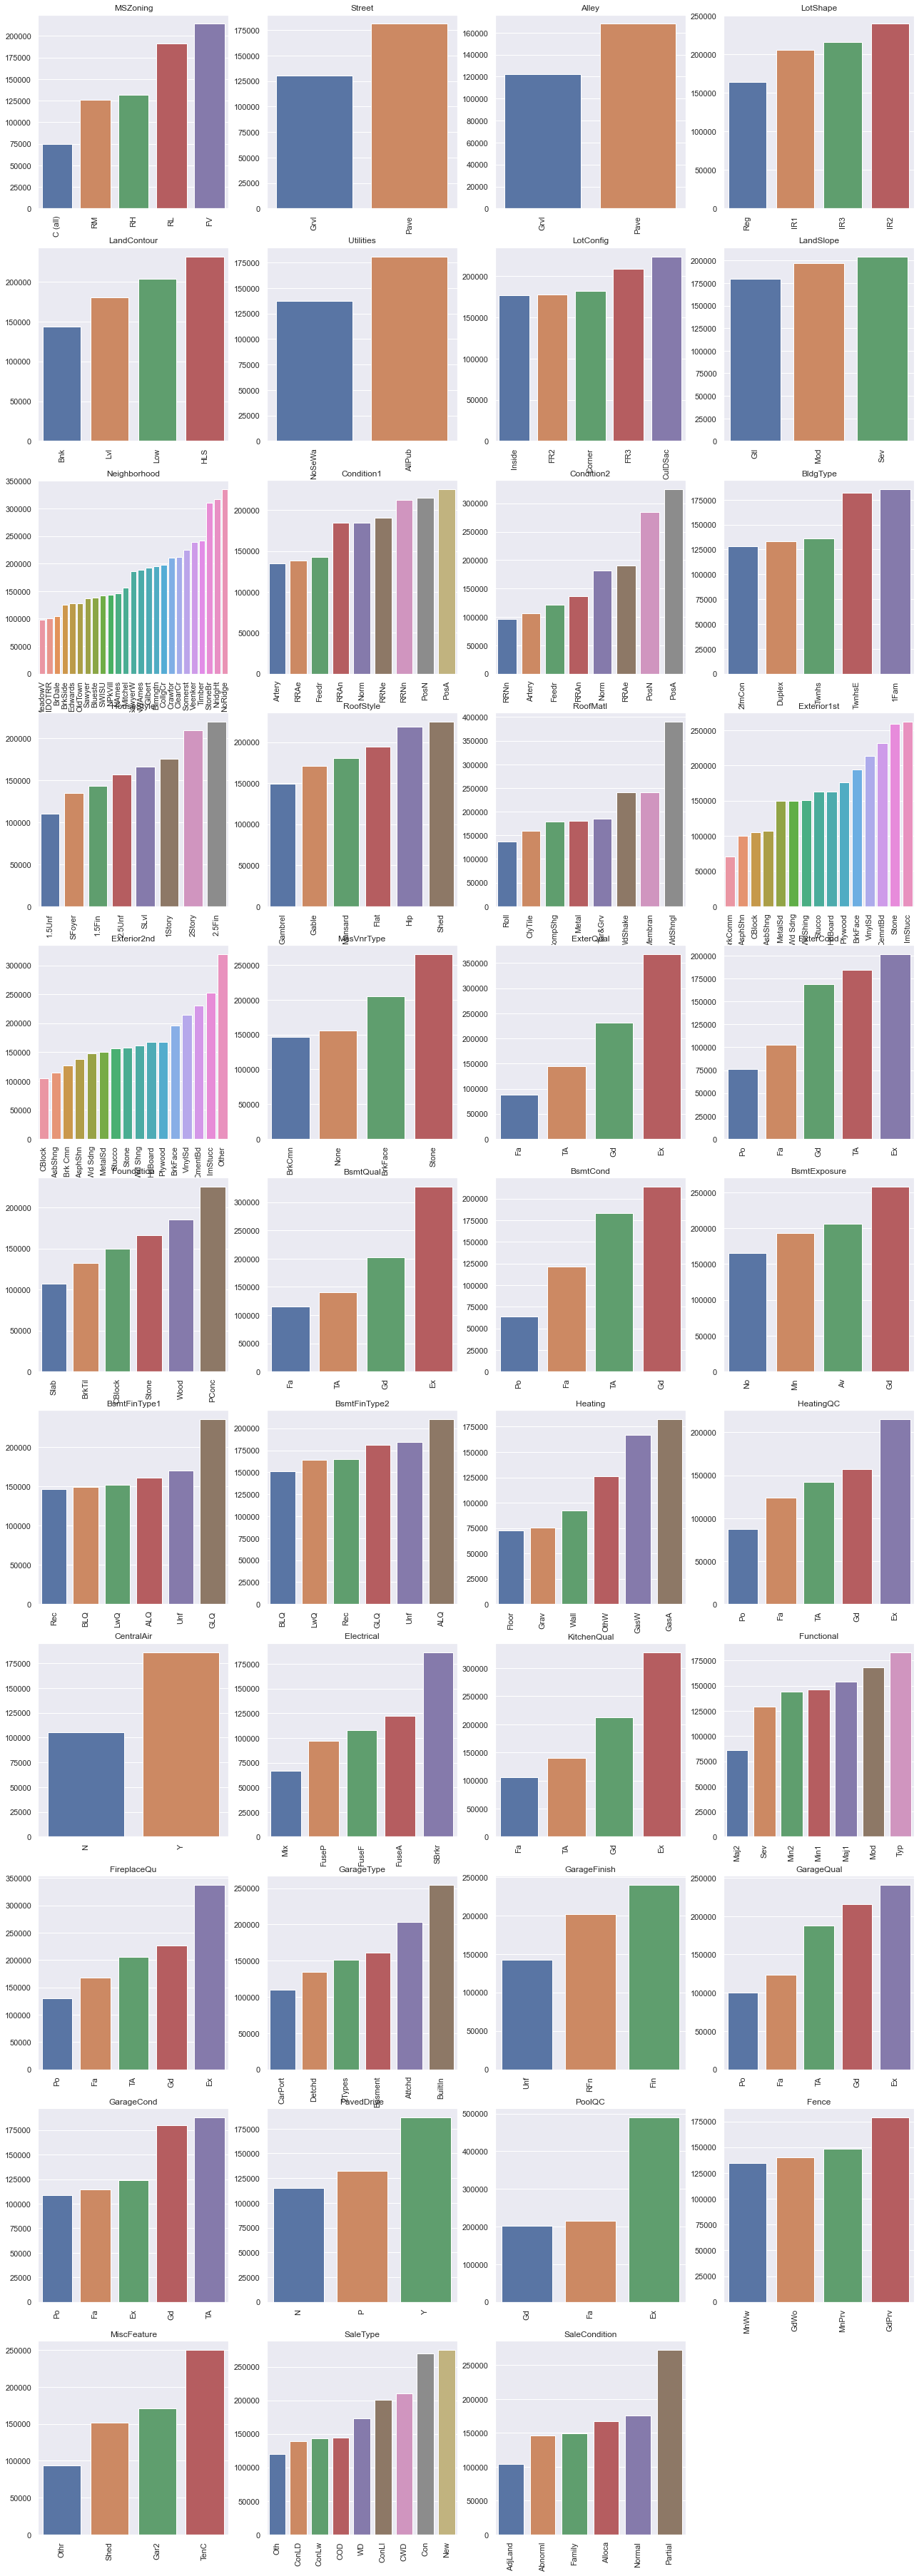

In [9]:
# Data Mining
# Lets now create a similar plot for categorical features

# creates area for subplots
plt.figure(figsize=(22, 65))

plt.xticks(rotation=90)

i = 1
for col in cl:
    mask_plot=ar['column']==col          # Boolean mask : if variable (col) is true or false in 'column' (in the lenght of entire dataframe)
    sar=ar[mask_plot]                    # returns rows of dataframe which have True value for their 'column'
    
    
    plt.subplot(11, 4, i)    # number of subplots (rows and columns), place of subplot, size of subplot
    plt.xticks(rotation=90)         #rotate names of variables
    plt.title(sar.iloc[1, 0])               #location of the column name, alternatively just use 'col'. Don't move before 'subplot'
    sns.barplot(x=list(sar['variable']), y=list(sar['mean price']))   # x returns the index (original variable names)
    
    i += 1

In [10]:
# Data Mining. Picture shows average price of a house for each unique value.
# Now, when uniting unique values we can also consider a correlation to our target.
# For example, we can now avoid uniting a 'low-priced' value with 'high-priced', and on a contrary, lean towards uniting similarly priced values.
# Uniting variables with similar mean prices will less likely distort the initial data in our dataset.
# It is also easier to see now, that our dataset has many ordinal categorical datatype, that we will later encode into continious numbers.

# So, values to unite:
# General zoning classification of the sale :
ds.MSZoning.replace({'RM':'RH','C (all)':'RH'}, inplace=True)
# Type of dwelling: 
ds.BldgType.replace({'2fmCon':'Twnhs','Duplex':'Twnhs','TwnhsE':'1Fam'}, inplace=True)
# Exterior covering on house:
ds.Exterior1st.replace({'AsphShn':'LwQual','BrkComm':'LwQual','CBlock':'LwQual','AsbShng':'LwQual',
                        'MetalSd':'Average','Wd Sdng':'Average','WdShing':'Average',
                        'HdBoard':'Average','Stucco':'Average','Plywood':'Average',
                        'BrkFace':'HiQual','CemntBd':'HiQual','VinylSd':'HiQual',
                        'Stone':'Premium','ImStucc':'Premium',}, inplace=True)
# Exterior covering on house (if more than one material): 
ds.Exterior2nd.replace({'AsphShn':'LwQual','Brk Cmn':'LwQual','CBlock':'LwQual','AsbShng':'LwQual',
                        'Wd Sdng':'Average','BrkFace':'Average','Stucco':'Average','Stone':'Average',
                        'MetalSd':'Average', 'Wd Shng':'Average','HdBoard':'Average','Plywood':'Average',
                        'Other':'Premium','VinylSd':'Premium','ImStucc':'Premium','CmentBd':'Premium'}, inplace=True)
# Rating of basement finished area: 
ds.BsmtFinType1.replace({'ALQ':'LwQ','Unf':'LwQ','Rec':'LwQ','BLQ':'LwQ'}, inplace=True)
# Rating of basement finished area (if multiple types)
ds.BsmtFinType2.replace({'Rec':'LwQ','GLQ':'ALQ','BLQ':'LwQ'}, inplace=True)
# Home functionality (Assume typical unless deductions are warranted):
ds.Functional.replace({'Min1':'Major','Min2':'Major','Maj1':'Major','Maj2':'Major','Sev':'Major','Mod':'Major'}, inplace=True)
# Garage condition
ds.GarageCond.replace({'Fa':'Po','Ex':'Gd'}, inplace=True)
# Pool Quality
ds.PoolQC.replace({'Gd':'Fa'}, inplace=True)
# Heating
ds.Heating.replace({'GasW':'GasA','Grav':'Other','Wall':'Other','Floor':'Other','OthW':'Other'}, inplace=True)
# Land Slope
ds.LandSlope.replace({'Sev':'Mod'}, inplace=True)
# General shape of property:
ds.LotShape.replace({'IR3':'IR2'}, inplace=True)
# Lot configuration:
ds.LotConfig.replace({'FR3':'FR2'}, inplace=True)
# Roof Material:
ds.RoofMatl.replace({'ClyTile':'Other','Membran':'Other','Metal':'Other','Roll':'Other','Tar&Grv':'Other','WdShake':'Other','WdShngl':'Other'}, inplace=True)
# Proximity to various conditions
ds.Condition1.replace({'RRAe':'Feedr','Artery':'Feedr','PosA':'PosN','RRNn':'PosN','RRNe':'PosN'}, inplace=True)
# Proximity to various conditions 
ds.Condition2.replace({'RRAe':'Other','Artery':'Other','PosA':'Other','RRNn':'Other','RRNe':'Other','PosN':'Other','Feedr':'Other','RRAn':'Other'}, inplace=True)
# Type of roof
ds.RoofStyle.replace({'Shed':'Hip','Mansard':'Flat','Gambrel':'Gable'}, inplace=True)
# Basement Condition
ds.BsmtCond.replace({'Po':'Fa'}, inplace=True)
# Exterier Condition
ds.ExterCond.replace({'Ex':'TA','Po':'Fa'}, inplace=True)
# Heating Quality
ds.HeatingQC.replace({'Po':'Fa'}, inplace=True)
# Electrical
ds.Electrical.replace({'Mix':'FuseF','FuseP':'FuseF'}, inplace=True)
# Garage Quality
ds.GarageQual.replace({'Po':'Fa','Ex':'Gd'}, inplace=True)
# Garage type
ds.GarageType.replace({'2Types':'Basment','CarPort':'Detchd'}, inplace=True)
# Type of sale
ds.SaleType.replace({'CWD':'WD','Con':'New','ConLI':'Con','ConLw':'Con','Oth':'Con','ConLD':'Con'}, inplace=True)
# Condition of sale
ds.SaleCondition.replace({'AdjLand':'Abnorml','Alloca':'Family'}, inplace=True)
# House Style
ds.HouseStyle.replace({'2.5Fin':'2Story','2.5Unf':'Unf','1.5Unf':'Unf'}, inplace=True)
# Foundation
ds.Foundation.replace({'Wood':'Slab','Stone':'CBlock'}, inplace=True)

# For columns:
#ds=ds.drop('Street', axis=1)
#ds=ds.drop('Utilities', axis=1)
#ds=ds.drop('Condition2', axis=1)
#ds=ds.drop('RoofMatl', axis=1)
#ds=ds.drop('Heating', axis=1)
# reset the list of categorical features
#obj = (ds.dtypes == 'object')   
#object_cols = list(obj[obj].index)



In [11]:
#Data Cleaning. Now that our values are properly grouped, lets encode the one of them that could be considered ordinal:
#Alley
ds.Alley.replace({'Grvl':1,'Pave':2}, inplace=True)
ds['Alley'].unique()
#Street
ds.Street.replace({'Grvl':1,'Pave':2}, inplace=True)
#Lot Shape
ds.LotShape.replace({'Reg':1, 'IR1':2, 'IR2': 3}, inplace=True)
# Building Type
ds.BldgType.replace({'Twnhs':1,'1Fam':2}, inplace=True)
# Land Contour
ds.LandContour.replace({ 'Bnk': 1, 'Lvl': 2,'Low':3,'HLS':4}, inplace=True)
# Utilities
ds.Utilities.replace({'NoSeWa':1,  'AllPub': 2}, inplace=True)
# Land Slope
ds.LandSlope.replace({'Gtl': 1,'Mod':2}, inplace=True)
# Exterior Quality
ds.ExterQual.replace({'Fa':1, 'TA': 2, 'Gd': 3,'Ex':4}, inplace=True)
# Exterior Condition
ds.ExterCond.replace({'Fa':1,'Gd': 2 ,'TA': 3}, inplace=True)
# Basement Quality
ds.BsmtQual.replace({'Fa':1, 'TA': 2, 'Gd': 3,'Ex':4}, inplace=True)
# Basement Condition
ds.BsmtCond.replace({'Fa':1, 'TA': 2, 'Gd': 3}, inplace=True)
# Basement Exposure
ds.BsmtExposure.replace({'No':1,'Mn':2, 'Av': 3, 'Gd': 4}, inplace=True)
# Finished Basement 1 Rating
ds.BsmtFinType1.replace({'LwQ':1,'GLQ':2}, inplace=True)
# Finished Basement 2 Rating
ds.BsmtFinType2.replace({ 'LwQ':1, 'Unf':2,'ALQ':3 }, inplace=True)
# Heating Quality and Condition
ds.HeatingQC.replace({'Fa':1, 'TA': 2, 'Gd': 3, 'Ex':4}, inplace=True)
# Kitchen Quality
ds.KitchenQual.replace({'Fa':1, 'TA': 2, 'Gd': 3, 'Ex':4}, inplace=True)
# Home functionality
ds.Functional.replace({'Major':1,'Minor':2, 'Typ': 3}, inplace=True)
# Fireplace Quality
ds.FireplaceQu.replace({'Po':1,'Fa':2, 'TA': 3, 'Gd': 4, 'Ex':5}, inplace=True)
# Garage Finish
ds.GarageFinish.replace({'Unf':1,'RFn':2, 'Fin': 3}, inplace=True)
# Garage Quality
ds.GarageQual.replace({'Fa':1, 'TA': 2, 'Gd': 3}, inplace=True)
# Garage Condition
ds.GarageCond.replace({'Po':1,'Gd': 2, 'TA': 3 }, inplace=True)
# Paved Driveway
ds.PavedDrive.replace({'N':1,'P':2, 'Y': 3}, inplace=True)
# Pool Quality
ds.PoolQC.replace({'Fa':1,'Ex':2}, inplace=True)
# Neighborhood 
ds.Neighborhood.replace({'MeadowV':1, 'IDOTRR':2, 'BrDale':3, 'BrkSide':4, 'Edwards':5, 'OldTown':6,
       'Sawyer':7, 'Blueste':8, 'SWISU':9, 'NPkVill':10, 'NAmes':11, 'Mitchel':12, 'SawyerW':13,
       'NWAmes':14, 'Gilbert':15, 'Blmngtn':16, 'CollgCr':17, 'Crawfor':18, 'ClearCr':19,
       'Somerst':20, 'Veenker':21, 'Timber':22, 'StoneBr':23, 'NoRidge':24, 'NridgHt':25},inplace=True)
# Pool Quality
ds.MSZoning.replace({'RH':1,'RL':2,'FV':3}, inplace=True)
# Condition of the house
ds.Condition1.replace({'Feedr':1,'Norm':2,'RRAn':3,'PosN':4}, inplace=True)
# Type of house
ds.HouseStyle.replace({'Unf':1,'SFoyer':2, '1.5Fin': 3, 'SLvl': 4, '1Story':5,'2Story':6}, inplace=True)
# Style of the roof
ds.RoofStyle.replace({'Gable':1,'Flat':2, 'Hip': 3}, inplace=True)
# Exteriour material quality
ds.Exterior1st.replace({'LwQual':1,'Average':2,'HiQual':3,'Premium':4}, inplace=True)
# Exteriour material quality (if multiple)
ds.Exterior2nd.replace({'LwQual':1,'Average':2,'Premium':3}, inplace=True)
# Masonry veneer type
ds.MasVnrType.replace({'BrkCmn':1,'None':2,'BrkFace':3,'Stone':4}, inplace=True)
# Foundation
ds.Foundation.replace({'Slab':1,'BrkTil':2,'CBlock':3,'PConc':4}, inplace=True)
# Type of garage
ds.GarageType.replace({'Detchd':1,'Basment':2,'Attchd':3,'BuiltIn':4}, inplace=True)
# Miscellaneous feature not covered in other categories
ds.MiscFeature.replace({'Othr':1,'Shed':2,'Gar2':3,'TenC':4}, inplace=True)
# Condition of sale
ds.SaleCondition.replace({'Abnorml':1,'Family':2,'Normal':3,'Partial':4}, inplace=True)

# Features converted:
cat_to_num_features = ['Alley','Street','LotShape','BldgType','LandContour','Utilities','LandSlope',
'ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
'HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','PavedDrive',
'PoolQC','SaleCondition','MiscFeature','GarageType','Foundation','MasVnrType','Exterior2nd','Exterior1st',
'RoofStyle','HouseStyle','Condition1','MSZoning','Neighborhood','GarageCond']
# Managing NaN values of those:
ds[cat_to_num_features] = ds[cat_to_num_features].fillna(0)
# reset the list of categorical features
obj = (ds.dtypes == 'object')   
object_cols = list(obj[obj].index)
# selecting converted colums that are float:
msk=ds[cat_to_num_features].dtypes==float
toint= []
msk=dict(msk)
for i in msk:
    if msk[i] == True:
        toint.append(i)

<AxesSubplot:xlabel='SalePrice'>

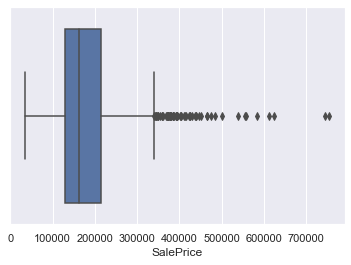

In [12]:
# Data Cleaning. Visualizing outliers

sns.boxplot(x=ds['SalePrice'])     


In [13]:
# Data Cleaning. Boolean Masks for outliers
mask_SP=ds['SalePrice']<ds['SalePrice'].mean()*3
ds=ds[mask_SP]
mask_BSF=ds['TotalBsmtSF']<ds['TotalBsmtSF'].mean()*3
ds=ds[mask_BSF]
mask_FFSF=ds['1stFlrSF']<ds['1stFlrSF'].mean()*3
ds=ds[mask_FFSF]
mask_GLA=ds['GrLivArea']<ds['GrLivArea'].mean()*2.8
ds=ds[mask_GLA].reset_index(drop=True)

In [14]:
# Data Cleaning. Searching for missing values
# Missing value counts in each columns [fl_cols]A
missing_count = (ds.isnull().sum())/len(ds)*100
#Filter to find the missing count > 0
missing_count=missing_count[missing_count>0]
print (missing_count.sort_values())
# Mask of float dtype
fl_mask=ds[missing_count.index].dtypes==float
#missing float values
missing_flcount=missing_count[fl_mask]
print(missing_flcount)

Electrical      0.069013
MasVnrArea      0.552105
GarageYrBlt     5.590062
LotFrontage    17.805383
Fence          80.676329
dtype: float64
LotFrontage    17.805383
MasVnrArea      0.552105
GarageYrBlt     5.590062
dtype: float64


In [15]:
# Data Cleaning. Dealing with missing values
# We have missing values for 2 types of columns : columns with float and object dtypes
# For object ones they will be managed automaticaly in the 'get_dummies' step.
# Float
# Linear feet of street connected to property. Filling missing values with average.
ds.LotFrontage.fillna(ds.LotFrontage.mean(),inplace=True)                   #ds.LotFrontage.mean()
# Garage Year Built. For this one we will replace missing values with average across the column
ds.GarageYrBlt.fillna(0,inplace=True)
# Masonry veneer area in square feet. Data is distributed in groups. Filling missing values with dominant group
ds.MasVnrArea.fillna(ds.MasVnrArea.value_counts().idxmax(),inplace=True)        # dominant group is '0'

In [16]:
# Data Cleaning
# After examining float values (in Data Cleaning step), we decided that it would make perfect sense if we convert them to 
# integer, so it will make data management simpler with only 2 data types:
ds = ds.astype({"LotFrontage":'int64', "MasVnrArea":'int64',"GarageYrBlt":'int64','Alley':'int64',
 'BsmtQual':'int64', 'BsmtCond':'int64', 'BsmtExposure':'int64', 'BsmtFinType1':'int64', 'BsmtFinType2':'int64', 
 'FireplaceQu':'int64', 'GarageFinish':'int64', 'GarageQual':'int64', 'PoolQC':'int64', 'MiscFeature':'int64',
  'GarageType':'int64', 'MasVnrType':'int64', 'GarageCond':'int64'})  


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

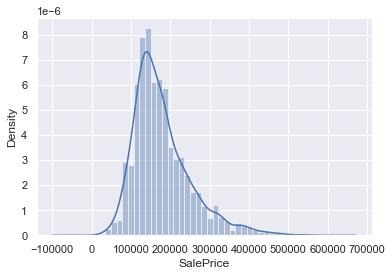

In [17]:
# Data Exploration

# Normal distribution check. Our distribution is "screwed" to the right side

sns.histplot(
    ds['SalePrice'], kde=True,
    stat="density", kde_kws=dict(cut=8),
    alpha=.4,)                              # kde=True - 'kernel density estimate' for the line, stat for y axis, kde_kws (unit multiplies 
                                            # kernels width), alpha - for color of bars


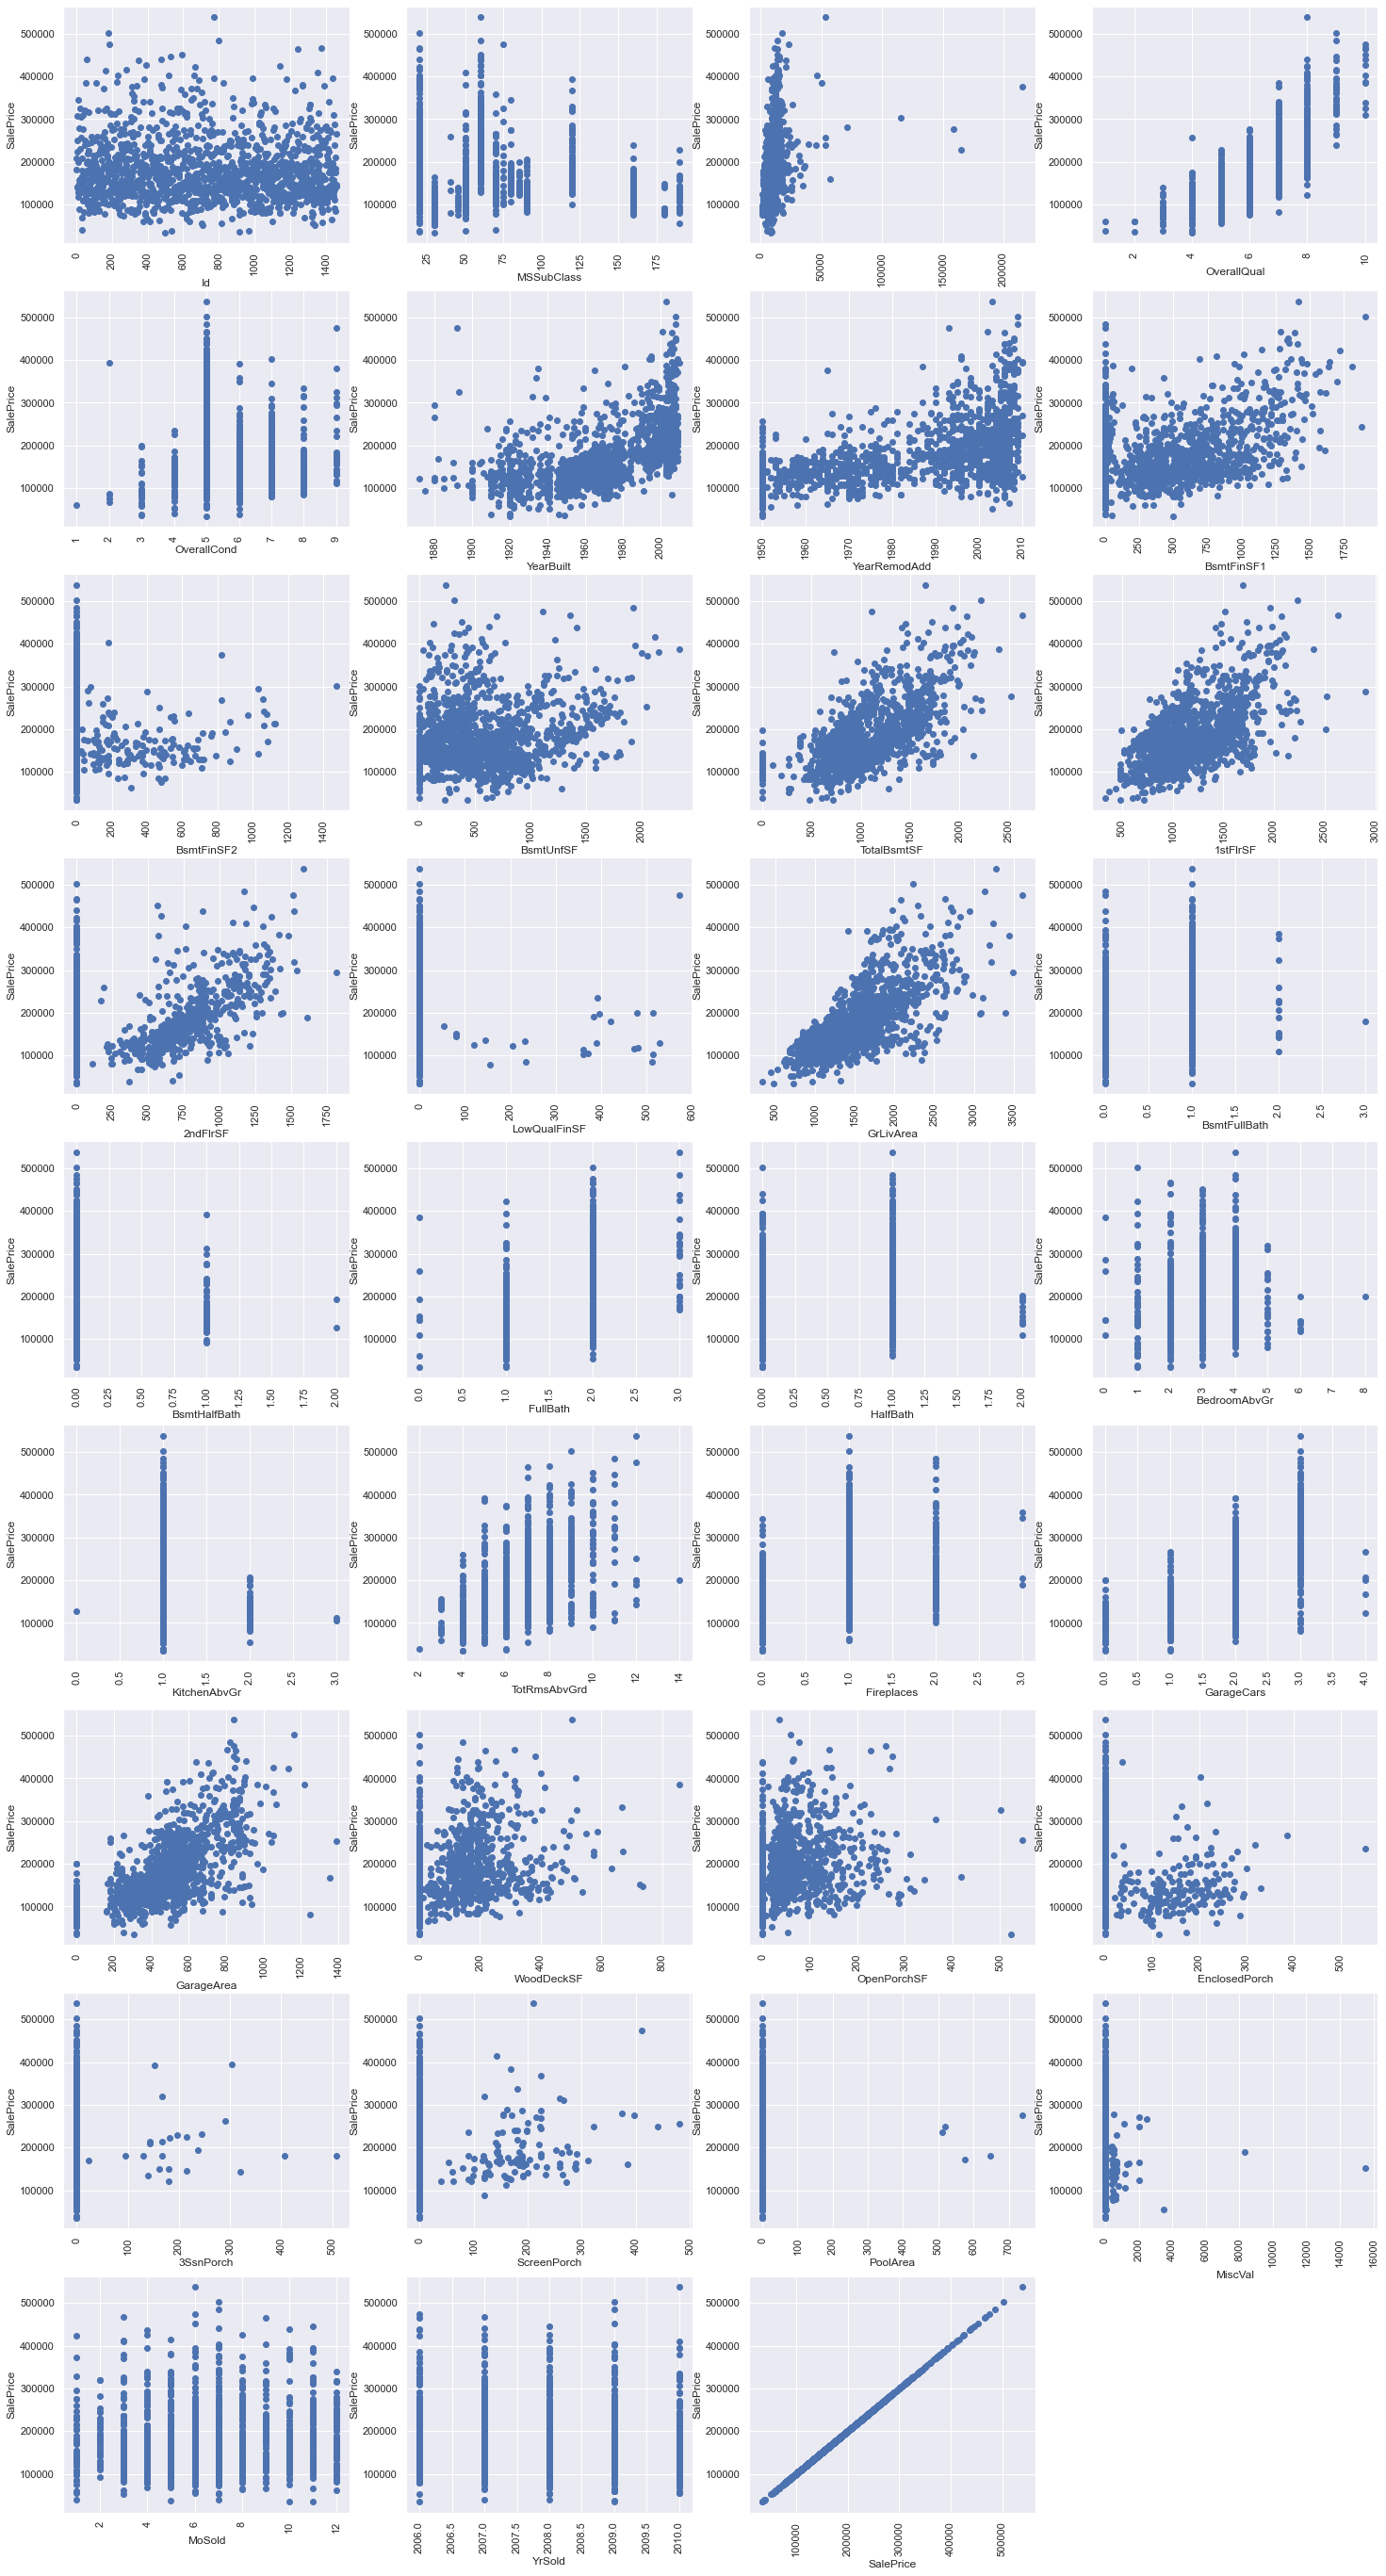

In [18]:
# Data Exploration
# Visualizing relations of integer attributes to house prices 

# creates area for subplots
plt.figure(figsize=(25, 60))  #area size
plt.title('Integer Features: Distribution') #area name

#shows relations between integer attributes and salesprice
i = 1

for col in range(len(num_cols)):
    plt.subplot(11, 4, i) #creates subplots 
    plt.xticks(rotation=90)
    plt.xlabel(num_cols[col])
    plt.scatter(ds[num_cols[col]],ds.SalePrice)   #draws scatter on subplot
    plt.ylabel('SalePrice')    
    i += 1


<AxesSubplot:>

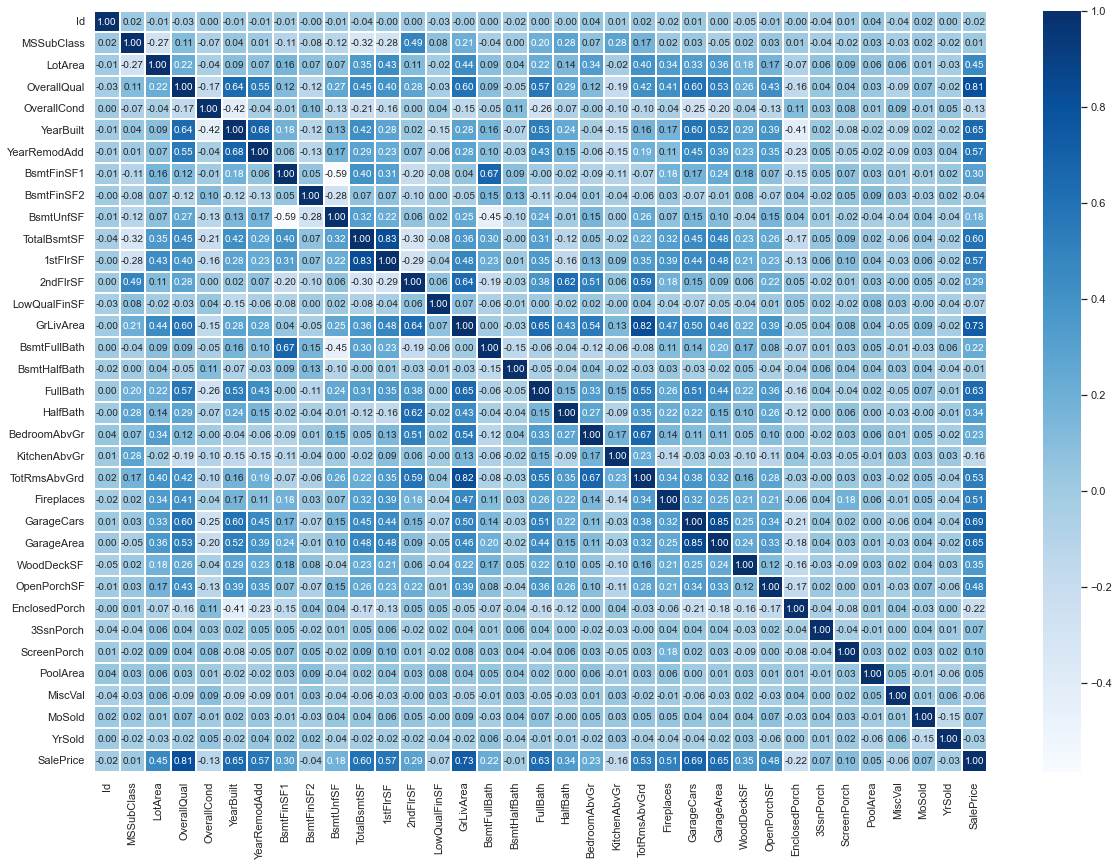

In [19]:
# Data Exploration. Heat map.
# We can argue that some of displayed columns are not useful for prediction of SalePrice (Id, PoolArea, etc.)
# In order to proof that, we will use another tool called HeatMap that will show us exact correlation of each column to SalePrice:
# Our interest is in the last row of the heatmap called 'SalePrice'. Our target's correlations to other featurs are show there:
plt.figure(figsize=(20, 14))

sns.heatmap(ds[num_cols].corr(method='spearman'),   #ds[num_cols]; 
            cmap = 'Blues',
            fmt = '.2f',
            linewidths = 2,
            annot = True)


In [20]:
# Feature Engineering: converting leftover categorical features into dummies:
# will exclude NaN feature automaticaly if 'dummy_na' is set to false (default)
# drop_first=True parameter eliminates variables (adviceable not to use, 
                                            #  as it removes valuable information form dataset)

ds2=ds[object_cols]

ds2d=pd.get_dummies(ds2,drop_first=False)  # drop_first=True parameter eliminates variables (adviceable not to use, 
                                            #  as it removes valuable information form dataset)
 
ds.drop(object_cols,axis=1,inplace=True)

ds=pd.concat([ds2d,ds],axis=1)   

In [21]:
# Feature Engineering: Stepwise Selection.
# Since Exaustive Search is still too heavy computationaly for our dataset, even after we did a good job at data cleaning,
#  we cannot use it for our dataset. 
# Preparing dataset for feature engeneering:
predict='SalePrice'

X=(ds.drop([predict],axis=1))    
y=(ds[predict])             #returns true values for labels, that we want to predict or test

x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2)  #spliting into train/test samples
def train_model(variables):
    if len(variables) == 0:
        return None
    model = linear_model.LinearRegression()
    model.fit(x_train[variables], y_train)
    return model
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(x_train[variables]), model)
best_model, best_variables = stepwise_selection(x_train.columns, train_model, score_model, verbose=True) #par direction='backward' to select 
                                                                                                        # backward selection exclusively


Variables: LotConfig_Corner, LotConfig_CulDSac, LotConfig_FR2, LotConfig_Inside, Condition2_Norm, Condition2_Other, RoofMatl_CompShg, RoofMatl_Other, Heating_GasA, Heating_Other, CentralAir_N, CentralAir_Y, Electrical_FuseA, Electrical_FuseF, Electrical_SBrkr, Fence_GdPrv, Fence_GdWo, Fence_MnPrv, Fence_MnWw, SaleType_COD, SaleType_Con, SaleType_New, SaleType_WD, Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LandSlope, Neighborhood, Condition1, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, HeatingQC, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, G

In [22]:
'''# Feature Engineering: Stepwise Selection.
# Since Exaustive Search is still too heavy computationaly for our dataset, even after we did a good job at data cleaning,
#  we cannot use it for our dataset. 
# Preparing dataset for feature engeneering:
predict='SalePrice'

X=(ds.drop([predict],axis=1))    #returns new dataframe, that doesn't have 'SalesPrice' in it
y=(ds[predict])             #returns true values for labels, that we want to predict or test

x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2)  #spliting into train/test samples
def train_model(variables):
    model = linear_model.LinearRegression()
    model.fit(x_train[variables], y_train)
    return model
def score_model(model, variables):
    return -adjusted_r2_score(y_train, model.predict(x_train[variables]),model)
# Assigning results:
allVariables = ds.drop(predict,axis=1).columns
best_model, best_variables = backward_elimination(allVariables, train_model, score_model, verbose=True)'''

"# Feature Engineering: Stepwise Selection.\n# Since Exaustive Search is still too heavy computationaly for our dataset, even after we did a good job at data cleaning,\n#  we cannot use it for our dataset. \n# Preparing dataset for feature engeneering:\npredict='SalePrice'\n\nX=(ds.drop([predict],axis=1))    #returns new dataframe, that doesn't have 'SalesPrice' in it\ny=(ds[predict])             #returns true values for labels, that we want to predict or test\n\nx_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2)  #spliting into train/test samples\ndef train_model(variables):\n    model = linear_model.LinearRegression()\n    model.fit(x_train[variables], y_train)\n    return model\ndef score_model(model, variables):\n    return -adjusted_r2_score(y_train, model.predict(x_train[variables]),model)\n# Assigning results:\nallVariables = ds.drop(predict,axis=1).columns\nbest_model, best_variables = backward_elimination(allVariables, train_model, score_

In [23]:
# Feature Engineering: results
print(best_variables)
regressionSummary(y_test, best_model.predict(x_test[best_variables]))


['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'Neighborhood', 'SaleType_New', 'TotalBsmtSF', 'KitchenQual', 'LotArea', 'MSSubClass', 'ExterQual', 'OverallCond', 'GarageArea', 'BsmtExposure', 'Functional', 'BedroomAbvGr', 'YearBuilt', 'MasVnrArea', 'SaleType_COD', 'FireplaceQu', 'GarageYrBlt', 'LotConfig_CulDSac', 'SaleCondition', 'LotFrontage', 'KitchenAbvGr', 'Electrical_SBrkr', 'WoodDeckSF', 'Exterior1st', 'ScreenPorch', 'Street', 'Utilities', 'LandContour', 'OpenPorchSF', 'RoofStyle', 'BsmtFullBath', 'Exterior2nd', 'GarageCars', 'MoSold', 'LowQualFinSF', 'BsmtCond', 'BsmtQual', 'GarageQual', 'GarageType']

Regression statistics

                      Mean Error (ME) : -257.9586
       Root Mean Squared Error (RMSE) : 23988.0517
            Mean Absolute Error (MAE) : 17693.7220
          Mean Percentage Error (MPE) : -0.7867
Mean Absolute Percentage Error (MAPE) : 11.3077


In [24]:
print("Before: ",len(ds.columns),"   After: ",len(best_variables))    #the count of columns before and after feature engineering

Before:  96    After:  42


In [25]:
# Feature Engineering + normalization (stored in ds_n variable).
# Results from normalization of numerical data differ from model to model. 
# KNR's accuracy was improved by 2-3% and SVR model was 'fixed' by normalization. Accuracy on training data is now higher than on test data. 
# Other models showed no improvements.
# Since normalization makes data unreadable, our decision is to use it only for KNR and SVR models.

ds=pd.concat([ds[best_variables],ds['SalePrice']],axis=1)   # dataset that we will use in prediction model

#Feature Engineering: normalizing data for SVR and KNR (used also for stepwise selection, hyperparameter tuning, and tried on other models)
ds_n=(ds-ds.min())/(ds.max()-ds.min())               # we will use ds_n as normalized dataset for KNR and SVR


Quick code for visualisation purposes:

<AxesSubplot:>

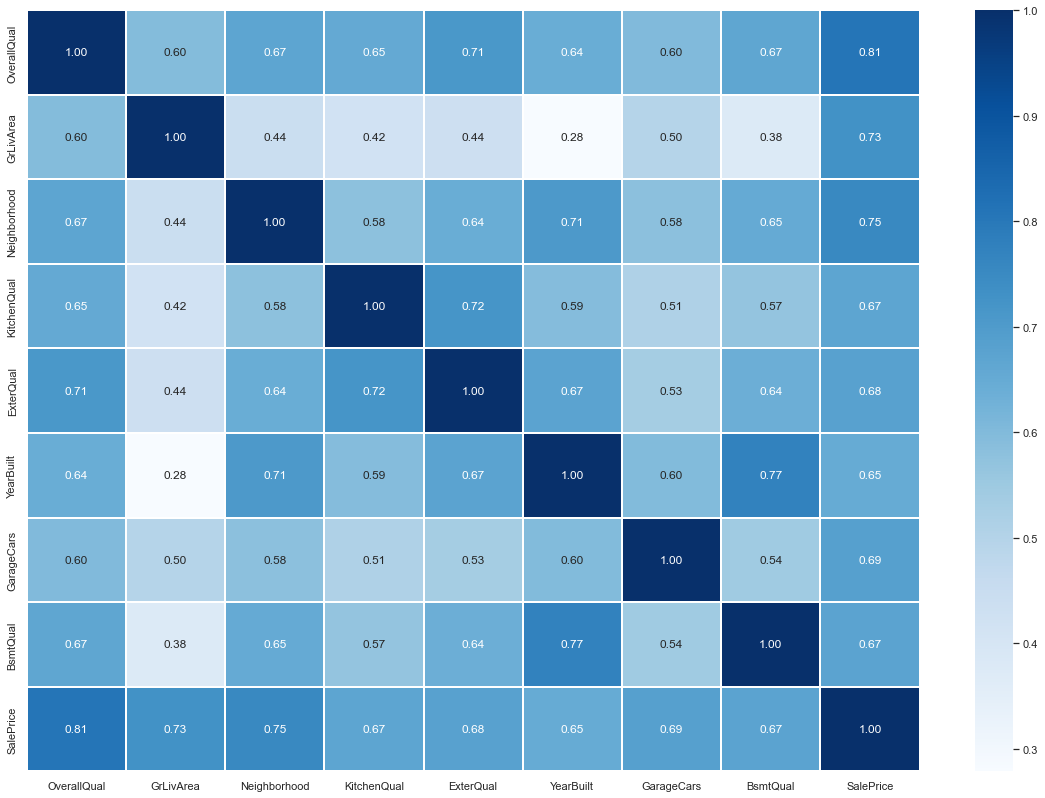

In [26]:
# Filters only highly correlated colums to display (using boolean mask and list)
ds_cor=ds.corr(method='spearman')
cor_mask=ds_cor>0.65         # regulate the correlation barrier
ds_cor_filt=ds_cor[cor_mask]
flist= list(ds_cor_filt.SalePrice.dropna().index)
plt.figure(figsize=(20, 14))
sns.heatmap(ds[flist].corr(method='spearman'),   
            cmap = 'Blues',
            fmt = '.2f',
            linewidths = 2,
            annot = True,
            annot_kws={'size': 12})

In [27]:
#calculate AIC and BIC for regressions
# calculate aic for regression
def calculate_aic(n, mse, num_params):
 aic = n * log(mse) + 2 * num_params
 return aic
# calculate bic for regression
def calculate_bic(n, mse, num_params):
 bic = n * log(mse) + num_params * log(n)
 return bic


In [28]:
# Training model: Linear regression
# Linear Regression is algorithm that analyses a scatter of data points and attempts to find
# a best-fit line that describes analysed data.
# Linear Regression creates this line on x,y axis: y=mx+b   (where y-predictive value, m- coefficient, b-constant/intercept)
# where m=(y2-y1)/(x2-x1)
# and number of attributes correspondes to number of dimensions (2 values- 2 dimencional, 3 values- 3 dim and so on)

X=np.array(ds.drop([predict],axis=1))        #returns new dataframe, that doesn't have 'SalesPrice' in it (numpy array makes tmodel work faster)
y=np.array(ds[predict])                      #returns true values for labels, that we want to predict or test
avg=[]
for i in range(500):
    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2)  #spliting into train/test samples
    linear = linear_model.LinearRegression()               #assigning the instance for our model type
    linear.fit(x_train,y_train)                     #fits this data to find the best fit line and will store it in 'linear'
    acc=linear.score(x_test,y_test)             #will represent accuracy of our model (R2), to see how accurate we can get
    avg.append(acc)                                 # used to calculate average accuracy of 500 cycles

print('Average accuracy of a model from 500 training cycles (R2):   %.5f '% mean(avg))
print('Current model accuracy (R2):   %.5f '% acc)
print('Max accuracy (R2):   %.5f '% max(avg)) # calculate mean error
print('Current accuracy on test data (R2):  %.5f '% linear.score(x_train,y_train))
#Model Evaluation
y_pred_mlr= linear.predict(x_test)
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('Mean Absolute Error: %.5f '%  meanAbErr)
print('Mean Square Error: %.5f '%  meanSqErr)
print('Root Mean Square Error: %.5f '% rootMeanSqErr)
# number of parameters
num_params = len(linear.coef_) + 1
# number of rows
n=len(y)
# calculate the aic
aic = calculate_aic(len(y), meanSqErr, num_params)
print('AIC: %.3f' % aic)
# calculate the bic
bic = calculate_bic(len(y), meanSqErr, num_params)
print('BIC: %.3f' % bic)
print('Adjusted R2 score:   %.5f '% adjusted_r2_score(y_test, y_pred_mlr, linear))


Average accuracy of a model from 500 training cycles (R2):   0.89730 
Current model accuracy (R2):   0.87391 
Max accuracy (R2):   0.92498 
Current accuracy on test data (R2):  0.91246 
Mean Absolute Error: 17403.09203 
Mean Square Error: 570703019.04208 
Root Mean Square Error: 23889.39135 
AIC: 29301.288
BIC: 29528.269
Adjusted R2 score:   0.85247 


In [29]:
# Hyperparameter tuning for KNR
#If we have a variable with undefined class that represents a point on Xy-axis (in 2 dimencions) and is is displaced on some distance
#from a multiple clusters of data points (each cluster represents a defined class), KNN
#alorithm finds the cluster to which undefined variable is most likely related (measuring the distance to the closest defined points, 
#and picking the cluster with the biggest number of close points).
#Number of points the algorithm counts from the nearby clusters is "k" (from the title KNN)
# define model
#model = KNeighborsRegressor()
# define evaluation
#cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1) # n_splits - number of folds, n_repeats - number of times CV will be repeated
# define search space
#space = dict()
#space['n_neighbors'] = [*range(1,21,1)]         #Number of neighbors to use
#space['weights'] = ['uniform', 'distance',]         # All points in each neighborhood are weighted equally or  closer neighbors of a query point 
                                                    # will have a greater influence than neighbors which are further away.
#space['p'] = [1,2]                              # When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2

# define search
#search = GridSearchCV(model, space, scoring='r2', n_jobs=-1, cv=cv)
# execute search
#result = search.fit(X, y)
# summarize result
#print('Best Score (R2): %.3f' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [30]:
# Training model: KNR (regression based on k-nearest neighbors)
# Normalized data used for this model

X=np.array(ds_n.drop([predict],axis=1))    #returns new dataframe, that doesn't have 'SalesPrice' in it
y=np.array(ds_n[predict])             #returns true values for labels, that we want to predict or test

avgkn=[]
for i in range(500):
    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2)  
    knn = KNeighborsRegressor(n_neighbors=8,p=1,weights='distance')    
    knn.fit(x_train,y_train)         #
    #yprkn = knn.predict(x_test)       
    acckn=knn.score(x_test,y_test)     #
    avgkn.append(acckn)

print('Average accuracy of a model from 500 training cycles (R2):   %.5f '% mean(avgkn))
print('Current model accuracy (R2):   %.5f '% acckn)
print('Max accuracy (R2):   %.5f '% max(avgkn)) # calculate mean error
print('Current accuracy on test data (R2):  %.5f '% knn.score(x_train,y_train))
#Model Evaluation

y_pred_mlr= knn.predict(x_test)
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('Mean Absolute Error:%.5f '%  meanAbErr)
print('Mean Square Error:%.5f '%  meanSqErr)
print('Root Mean Square Error:%.5f '% rootMeanSqErr)
# number of parameters
num_params = len(ds.columns) 
# number of rows
n=len(y)
# calculate the aic
aic = calculate_aic(len(y), meanSqErr, num_params)
print('AIC: %.3f' % aic)
# calculate the bic
bic = calculate_bic(len(y), meanSqErr, num_params)
print('BIC: %.3f' % bic)


Average accuracy of a model from 500 training cycles (R2):   0.82831 
Current model accuracy (R2):   0.84093 
Max accuracy (R2):   0.88921 
Current accuracy on test data (R2):  1.00000 
Mean Absolute Error:0.03873 
Mean Square Error:0.00323 
Root Mean Square Error:0.05683 
AIC: -8224.396
BIC: -7997.415


In [31]:
# Hyperparameter tuning for SVR 
# super heavy computationaly, I used manual tuning for SVR. Random Search CV could be considered for this one
# Attempts to create a hyperplane (something straight, a straight line between clusters of data, for example)
# Hyperplane is a line between clusters of data points and is perpendicular to the beam towards hyperplane from
# the closest point of each cluster. The distance between hyperplane and data points from each side should be exactly the same.
# In our case we want to pick hyperplane with the biggest distance to datapoints, which will mean a bigger MARGIN.
# In case if data is randomly distributed on an XY-axis, SVM adds additional dimension to try and draw a hyperplane
# that will devide our data in to groups. This is done with the help of kernel (or just a function, which takes f(x1,x2) and returns x3)
# Also there is a "soft margin", which alows some outliers between the clusters 
# define model
#model = SVR()
# define evaluation
#cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1) # n_splits - number of folds, n_repeats - number of times CV will be repeated
# define search space
#space = dict()
#space['kernel'] = ['linear','poly','rbf']         # rbf is default, sigmoind unnescessary
#space['C'] = [*np.arange(0.005,0.05,0.005)]                  # Regularization parameter. The strength of the regularization is inversely proportional to C. 
                                                            #Must be strictly positive. The penalty is a squared l2 penalty
#space['epsilon']=[*np.arange(0.0,0.05,0.005)]              # It specifies the epsilon-tube within which 
                                                            #no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
#space['shrinking']=[True,False] 
# define search
#search = GridSearchCV(model, space, scoring='r2', n_jobs=-1, cv=cv)
# execute search
#result = search.fit(X, y)
# summarize result
#print('Best Score (R2): %.3f' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [32]:
# Training model: SVR (support vector regression). Best Performing Model!
# Normalized data used for this model

X=np.array(ds_n.drop([predict],axis=1))   
y=np.array(ds_n[predict])            
#eps_c=0.001
#eps_cli=[]
avsvr=[]
for i in range(50):
    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2)
    svrr = SVR(kernel='poly',epsilon=0.005,C=0.033,shrinking=True)        # shrinking reduces computing time drastically
    svrr.fit(x_train,y_train)
    accsvr=svrr.score(x_test,y_test)   
    avsvr.append(accsvr)
    #eps_cli.append(eps_c)
    #eps_c+=0.002
print('Average accuracy of a model from 50 training cycles (R2):  %.5f '% mean(avsvr))
print('Current model accuracy (R2):   %.5f '% accsvr)
print('Max accuracy (R2):   %.5f '%max(avsvr))
print('Current accuracy on train data (R2):  %.5f '%svrr.score(x_train,y_train))
#Model Evaluation
y_pred_mlr= svrr.predict(x_test)
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))       
print('Mean Absolute Error:%.5f '% meanAbErr)
print('Mean Square Error:%.5f '% meanSqErr)
print('Root Mean Square Error:%.5f '% rootMeanSqErr)
# number of parameters
num_params = len(ds.columns) 
# number of rows
n=len(y)
# calculate the aic
aic = calculate_aic(len(y), meanSqErr, num_params)
print('AIC: %.3f' % aic)
# calculate the bic
bic = calculate_bic(len(y), meanSqErr, num_params)
print('BIC: %.3f' % bic)

Average accuracy of a model from 50 training cycles (R2):  0.92649 
Current model accuracy (R2):   0.92606 
Max accuracy (R2):   0.95357 
Current accuracy on train data (R2):  0.95067 
Mean Absolute Error:0.02608 
Mean Square Error:0.00151 
Root Mean Square Error:0.03881 
AIC: -9329.967
BIC: -9102.986


Text(0.5, 0, "Epsilon for SVR's hyperplane")

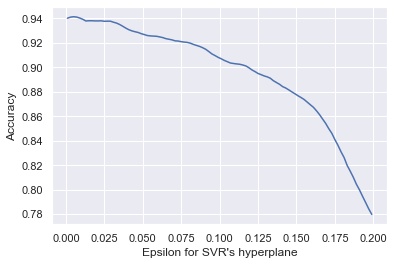

In [33]:
# Visualizing SVR Hyperparameter's relation to accuracy
epsilon_=[0.001, 0.003, 0.005, 0.007, 0.009000000000000001, 0.011000000000000001, 0.013000000000000001, 0.015000000000000001, 0.017, 0.019000000000000003, 0.021000000000000005, 0.023000000000000007, 0.02500000000000001, 0.02700000000000001, 0.029000000000000012, 0.031000000000000014, 0.033000000000000015, 0.03500000000000002, 0.03700000000000002, 0.03900000000000002, 0.04100000000000002, 0.043000000000000024, 0.045000000000000026, 0.04700000000000003, 0.04900000000000003, 0.05100000000000003, 0.05300000000000003, 0.055000000000000035, 0.05700000000000004, 0.05900000000000004, 0.06100000000000004, 0.06300000000000004, 0.06500000000000004, 0.06700000000000005, 0.06900000000000005, 0.07100000000000005, 0.07300000000000005, 0.07500000000000005, 0.07700000000000005, 0.07900000000000006, 0.08100000000000006, 0.08300000000000006, 0.08500000000000006, 0.08700000000000006, 0.08900000000000007, 0.09100000000000007, 0.09300000000000007, 0.09500000000000007, 0.09700000000000007, 0.09900000000000007, 0.10100000000000008, 0.10300000000000008, 0.10500000000000008, 0.10700000000000008, 0.10900000000000008, 0.11100000000000008, 0.11300000000000009, 0.11500000000000009, 0.11700000000000009, 0.11900000000000009, 0.1210000000000001, 0.1230000000000001, 0.12500000000000008, 0.12700000000000009, 0.1290000000000001, 0.1310000000000001, 0.1330000000000001, 0.1350000000000001, 0.1370000000000001, 0.1390000000000001, 0.1410000000000001, 0.1430000000000001, 0.1450000000000001, 0.1470000000000001, 0.1490000000000001, 0.1510000000000001, 0.1530000000000001, 0.1550000000000001, 0.1570000000000001, 0.1590000000000001, 0.16100000000000012, 0.16300000000000012, 0.16500000000000012, 0.16700000000000012, 0.16900000000000012, 0.17100000000000012, 0.17300000000000013, 0.17500000000000013, 0.17700000000000013, 0.17900000000000013, 0.18100000000000013, 0.18300000000000013, 0.18500000000000014, 0.18700000000000014, 0.18900000000000014, 0.19100000000000014, 0.19300000000000014, 0.19500000000000015, 0.19700000000000015, 0.19900000000000015]
accurat0=[0.9401153396270885, 0.9410216929151068, 0.9413317236153008, 0.9410779720265181, 0.9402864987641578, 0.9392448574888135, 0.9378696220647338, 0.9380544095525505, 0.9380469881635383, 0.9379242885424218, 0.9379192302392486, 0.9379856225889412, 0.9376415040423642, 0.9377201784746438, 0.9376931702340513, 0.9368508737246449, 0.9361336148530746, 0.9349809337133569, 0.9335478097594828, 0.9320320079433075, 0.9307141465984844, 0.9297606986429722, 0.929075641976671, 0.9284881563640126, 0.9275078262728031, 0.9267603529007258, 0.925985987550944, 0.9256661909797379, 0.9255150172008828, 0.9253584332576184, 0.9248617155878966, 0.9243031517009003, 0.9234557569464711, 0.9229536782150215, 0.9224483175844482, 0.921648886745397, 0.921463782922571, 0.920988999823071, 0.9206073192520559, 0.9203624508157945, 0.9197154766938983, 0.9186942954373166, 0.9178874015016908, 0.9170772851077248, 0.9160167070270746, 0.9147015201804375, 0.9128703772859481, 0.9109509686228039, 0.9096198161300135, 0.9081754686669169, 0.9070062229050535, 0.9056765746367276, 0.9046272911072478, 0.903540647785283, 0.9031312104527749, 0.902793812492318, 0.9025224514319347, 0.9019287160763275, 0.9011700310561022, 0.8997113351093996, 0.8978982175511787, 0.8965163963040624, 0.8949809671992026, 0.8940001168294459, 0.8929594408105186, 0.8921981495586166, 0.891068078557686, 0.8890500330172345, 0.887558497695307, 0.8861188799363184, 0.884235791677609, 0.8830929353378523, 0.8815558556029032, 0.8799259683736402, 0.8783912545715369, 0.8767568476234026, 0.8752954366147752, 0.873680800137397, 0.8715730058304454, 0.8694297741965699, 0.8673724608904632, 0.8645090565898063, 0.8613688962608724, 0.8577539733074453, 0.854175838968203, 0.8498936392653775, 0.8460824083207776, 0.8409327463663305, 0.836240338969952, 0.8309417822936422, 0.8262312360934195, 0.819777798149729, 0.8150883612051462, 0.8100809970273393, 0.804436366443104, 0.7998335818959452, 0.7945747067688814, 0.7895072212697701, 0.7843362623800172, 0.7797794696038755]
fig = plt.figure()
ax = plt.axes() 
ax.plot(epsilon_, accurat0)
plt.ylabel('Accuracy')  
plt.xlabel("Epsilon for SVR's hyperplane")  

Text(0.5, 1.0, 'Predicted')

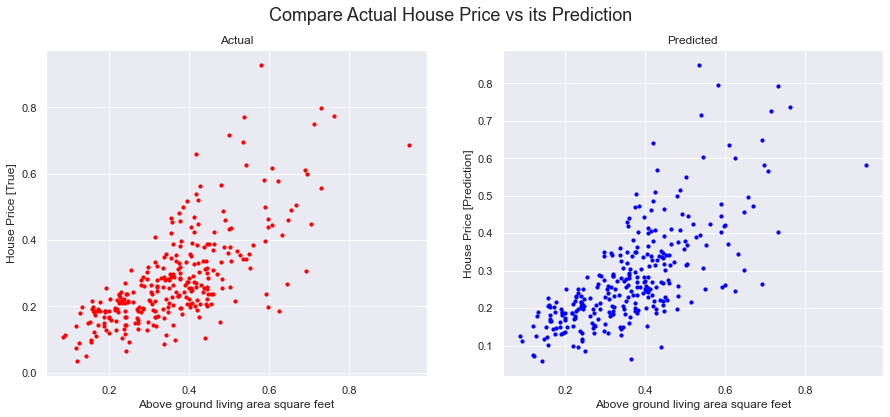

In [34]:
p='GrLivArea'
cx=ds.columns.get_loc(p) 

plt.figure(figsize=[15,6])  #area size
plt.suptitle('Compare Actual House Price vs its Prediction',fontsize=18) #area name

#DISPLAYING ACTUAL DATA:

x_te=pd.DataFrame(x_test)
plt.subplot(1,2,1)              # number of rows, number of columns,number of position(if the same for both, would print data on 1 subplot)
plt.scatter(x_te[cx],y_test,color='red',s=10)          #sets up scatter plot (instead of line-type, for example), with "x" and "y" 
                                            #values given in brackets as attributes of dataset
plt.xlabel('Above ground living area square feet')
plt.ylabel('House Price [True]')    
plt.title('Actual')

#DISPLAYING PREDICTIONS:

pr=svrr.predict(x_test)
x_tes=pd.DataFrame(x_test)
plt.subplot(1,2,2)         
plt.scatter(x_tes[cx],pr,color='blue',s=10)
plt.ylabel('House Price [Prediction]')  
plt.xlabel('Above ground living area square feet')            #ds.columns[cx]
plt.title('Predicted')

# some shapes:

In [35]:
# Hyperparameter tuning for Ridge
# The L2 norm loss function, also known as the least squares error (LSE), 
# is used to minimize the sum of the square of differences between the target value and the estimated value
#   S= E(y-f(x))^2
# less robust to outliers than L1 since error is squared
# define model
#model = Ridge()
# define evaluation
#cv = RepeatedKFold(n_splits=5, n_repeats=10,random_state=None) # n_splits - number of folds, n_repeats - number of times CV will be repeated
# define search space
#space = dict()
#space['alpha'] = [*np.arange(0.01,1.5,0.01)]         #Constant that multiplies the L2 term, controlling regularization strength
# define search
#search = GridSearchCV(model, space, scoring='r2', n_jobs=-1, cv=cv)     #n_jobs=-1 - number of jobs run in parallel: using all processors 
# execute search
#result = search.fit(X, y)
# summarize result
#print('Best Score (R2): %.3f' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [36]:
# Model training: Ridge Regression, which adds L2 Regularization to LinearRegression model. 
# Adds “squared magnitude” of coefficient as penalty term to the loss function

X=np.array(ds.drop([predict],axis=1))    #returns new dataframe, that doesn't have 'SalesPrice' in it (numpy array makes tmodel work faster)
y=np.array(ds[predict])   
avri=[]
for i in range(500):
    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2)
    ridgeReg = Ridge(solver='svd',alpha=0.47)         # alpha parameter differentiates this model from LinearRegression (if not 0), solver is BIG ('auto')
    rid=ridgeReg.fit(x_train,y_train)                   # 'svd' is the best solver (most stable)
    
           
    acri=rid.score(x_test,y_test)     
    avri.append(acri)

print('Average accuracy of a model from 500 training cycles (R2):   %.5f '% mean(avri))
print('Current model accuracy (R2):   %.5f '% acri)
print('Max accuracy (R2):   %.5f '% max(avri)) # calculate mean error
print('Accuracy on training data (current) (R2): %.5f '% rid.score(x_train, y_train))
#Model Evaluation
y_pred_rfr= rid.predict(x_test)
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_rfr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_rfr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfr))
print('Mean Absolute Error:    %.5f '%  meanAbErr)
print('Mean Square Error:    %.5f '%  meanSqErr)
print('Root Mean Square Error:    %.5f '%  rootMeanSqErr)
# calculate the aic
aic = calculate_aic(len(y), meanSqErr, num_params)
print('AIC: %.3f' % aic)
# calculate the bic
bic = calculate_bic(len(y), meanSqErr, num_params)
print('BIC: %.3f' % bic)


Average accuracy of a model from 500 training cycles (R2):   0.89664 
Current model accuracy (R2):   0.89155 
Max accuracy (R2):   0.92421 
Accuracy on training data (current) (R2): 0.90838 
Mean Absolute Error:    16038.25077 
Mean Square Error:    469015957.78889 
Root Mean Square Error:    21656.77626 
AIC: 29016.948
BIC: 29243.929


In [37]:
# Hyperparameter tuning for GradientBooster:

# define model
#model = GradientBoostingRegressor()
# define evaluation
#cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1) # n_splits - number of folds, n_repeats - number of times CV will be repeated
# define search space
#space = dict()
#space['n_estimators'] = [*range(70,250,10)]                                # The number of boosting stages to perform
#space['loss'] = ['squared_error','absolute_error','huber', 'quantile']         # Loss function to be optimized
#space['learning_rate'] = [*np.arange(0.01,0.2,0.05)]                   #Learning rate shrinks the contribution of each tree by learning_rate
#space['criterion'] = ['squared_error','friedman_mse']                   # The function to measure the quality of a split (about error)
#space['alpha']=[*np.arange(0.1,1,0.1)]                                    #The alpha-quantile of the huber loss function and the quantile loss function
#space['subsample']=[*np.arange(0.1,0.9,0.1)]                          #The fraction of samples to be used for fitting the individual base learners. 
                                                                    #If smaller than 1.0 this results in Stochastic Gradient Boosting 
                                                                    # (if lower than 1.0 reduces variance and increases bias)
#define search
#search = RandomizedSearchCV(model, space, scoring='r2', n_jobs=-1, cv=cv,verbose=True)    #grid=exaustive search
#execute search
#result = search.fit(X, y)
# summarize result
#print('Best Score: %s' % result.best_score_)
#print('Best Hyperparameters: %s' % result.best_params_)

In [111]:
# Gradient Booster.

X=np.array(ds.drop([predict],axis=1))   
y=np.array(ds[predict])   
avrf=[]
#n_estimators=[]
#n=0.01
for i in range(1):
    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.2,random_state=None)  
    gbr = GradientBoostingRegressor(n_estimators= 230, loss='huber',learning_rate= 0.09, 
                                    criterion='friedman_mse',max_depth= 3,subsample=0.34,alpha=0.9,
                                    validation_fraction= 0.54)
    #n_estimators.append(n)
    #n+=0.01                        
    gbr=gbr.fit(x_train, y_train)        
    acrf=gbr.score(x_test,y_test)     
    avrf.append(acrf)

print('Average accuracy of a model from 50 training cycles (R2):   %.5f '% mean(avrf))
print('Current model accuracy (R2):   %.5f '% acrf)
print('Max accuracy (R2):   %.5f '% max(avrf)) # calculate mean error
print('Accuracy on training data (current) (R2): %.5f '% gbr.score(x_train, y_train))
#Model Evaluation
y_pred_gbr= gbr.predict(x_test)
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_gbr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_gbr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbr))
print('Mean Absolute Error:   %.5f '%  meanAbErr)
print('Mean Square Error:   %.5f '%  meanSqErr)
print('Root Mean Square Error:   %.5f '%  rootMeanSqErr)
# calculate the aic
aic = calculate_aic(len(y), meanSqErr, num_params)
print('AIC: %.3f' % aic)
# calculate the bic
bic = calculate_bic(len(y), meanSqErr, num_params)
print('BIC: %.3f' % bic)

Average accuracy of a model from 50 training cycles (R2):   0.90636 
Current model accuracy (R2):   0.90636 
Max accuracy (R2):   0.90636 
Accuracy on training data (current) (R2): 0.96900 
Mean Absolute Error:   14089.59828 
Mean Square Error:   541851185.07853 
Root Mean Square Error:   23277.69716 
AIC: 29226.117
BIC: 29453.098


Text(0.5, 1.0, 'Predicted')

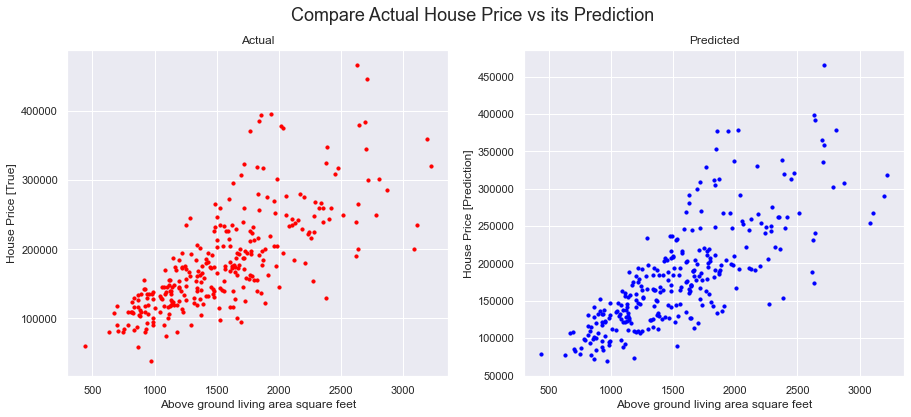

In [102]:

#COMMON PLOT:

plt.figure(figsize=[15,6])  #area size
plt.suptitle('Compare Actual House Price vs its Prediction',fontsize=18) #area name

#DISPLAYING ACTUAL DATA:

x_te=pd.DataFrame(x_test)
plt.subplot(1,2,1)              # number of rows, number of columns,number of position(if the same for both, would print data on 1 subplot)
plt.scatter(x_te[cx],y_test,color='red',s=10)          #sets up scatter plot (instead of line-type, for example), with "x" and "y" 
                                            #values given in brackets as attributes of dataset
plt.xlabel('Above ground living area square feet')
plt.ylabel('House Price [True]')    
plt.title('Actual')

    
#DISPLAYING PREDICTIONS:

pr=gbr.predict(x_test)
x_tes=pd.DataFrame(x_test)
plt.subplot(1,2,2)         
plt.scatter(x_tes[cx],pr,color='blue',s=10)
plt.ylabel('House Price [Prediction]')  
plt.xlabel('Above ground living area square feet')            #ds.columns[cx]
plt.title('Predicted')

# some shapes:
#print(x_train.shape,pr.shape,pm)

Text(0.5, 1.0, 'Actual=RED, Predicted=BLUE')

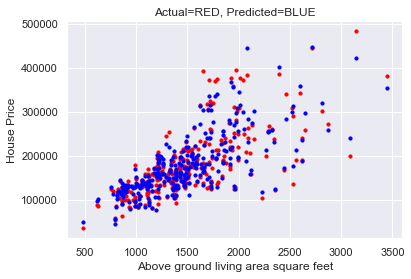

In [40]:
# alternative display (mixed)
plt.subplot()         
plt.scatter(x_te[cx],y_test,color='red',s=10)
plt.scatter(x_tes[cx],pr,color='blue',s=10)
plt.ylabel('House Price')  
plt.xlabel('Above ground living area square feet')            #ds.columns[cx]
plt.title('Actual=RED, Predicted=BLUE')

In [112]:
#displaying the predicted and actual values

predictions=gbr.predict(x_test)        #we use x_test, because it's data wasn't processed (using sklearn processing)
print('Predictions:  ', '    Actual Sale Price:')
for x in range(15):         #takes an array of arrays (x_test) len(predictions)
    if predictions[x]<100000:
        print('%.0f '%  predictions[x],'     |     ',y_test[x])
    else:
        print('%.0f '%  predictions[x],'    |     ',y_test[x])

Predictions:       Actual Sale Price:
133987      |      143500
128552      |      125500
299796      |      325000
172315      |      157000
236510      |      228950
129804      |      119500
87054       |      76500
226556      |      239000
106294      |      105900
199970      |      195400
349206      |      377500
175575      |      159500
82943       |      81000
235648      |      226000
164853      |      175500


Text(0.5, 0, 'The number of boosting stages performed')

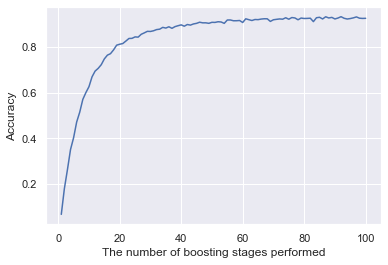

In [251]:
# From Random forest (model not included in this file): 
n_est=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
# Accuracy result
accurat1=[0.06634284087774978, 0.17900374711519107, 0.2624102386095122, 0.3504844157487974, 0.4022578992063076, 0.47116792524294915, 0.5144313702243372, 0.5703183342458327, 0.6001625206936594, 0.626014931108706, 0.6691681222328765, 0.6944794165490621, 0.7063988257770644, 0.7224862674827872, 0.7478512267873898, 0.764299450656387, 0.7707532112720549, 0.7873143872039765, 0.8079551143957566, 0.8121760480235478, 0.8151642235276063, 0.8259629734109731, 0.8373562278275799, 0.8379456450065457, 0.844340643869184, 0.8432518158192281, 0.8557907413989337, 0.861953753863709, 0.8686884616381889, 0.8681444876654827, 0.8711458006293102, 0.8763610803653905, 0.8781314269253903, 0.8860495930161093, 0.8830219220473867, 0.8886990749671057, 0.8819522466587605, 0.8894021056941881, 0.8933839513874839, 0.8970427571617121, 0.8911555799160735, 0.898595284991038, 0.8959882354156998, 0.9011103712051903, 0.9036899001138596, 0.9086740109571452, 0.9059128330634707, 0.905985278825849, 0.9038115495786011, 0.9082073371208614, 0.9077990005502818, 0.9107155699602738, 0.9096436696425286, 0.9036525955230911, 0.9183633092620133, 0.9184846888967979, 0.915045275432615, 0.9151804572118878, 0.9161741412491948, 0.9074920452588507, 0.9236294181771295, 0.9197544907588439, 0.9161760843991146, 0.9205576761372619, 0.9199347942909957, 0.9224551346614025, 0.9238111638933806, 0.9236243801523838, 0.9121822454016814, 0.9193879365892713, 0.9212787433244481, 0.9230278411377152, 0.9219386582092179, 0.9282888108496783, 0.9218253422820888, 0.9291436982540893, 0.927296771250003, 0.9193923376949451, 0.9268848292474916, 0.9250034888448794, 0.925408880903809, 0.9262427783857995, 0.911282342447665, 0.9282920163307364, 0.930282043918705, 0.9229172522018464, 0.93260744347291, 0.927282943713233, 0.929788380674313, 0.9229792271691463, 0.9269939674797715, 0.9328625254213184, 0.9259080681825941, 0.9227150404209915, 0.9247064904423147, 0.927734950292422, 0.9319269187145675, 0.9262437582197253, 0.9252791947440739, 0.9257997891670842]
fig = plt.figure() # a single container that contains all the objects representing axes, graphics, text, and labels
ax = plt.axes() # box with ticks and labels, which will eventually contain the plot elements
ax.plot(n_est, accurat1)
plt.ylabel('Accuracy')  
plt.xlabel('The number of boosting stages performed')  


Text(0.5, 0, 'The fraction of samples used for fitting the individual base learners')

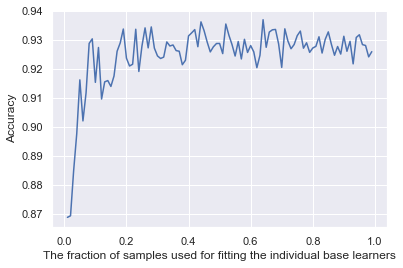

In [252]:
# From Random forest(model not included in this file): 
max_feat=[0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09, 0.09999999999999999, 0.10999999999999999, 0.11999999999999998, 0.12999999999999998, 0.13999999999999999, 0.15, 0.16, 0.17, 0.18000000000000002, 0.19000000000000003, 0.20000000000000004, 0.21000000000000005, 0.22000000000000006, 0.23000000000000007, 0.24000000000000007, 0.25000000000000006, 0.26000000000000006, 0.2700000000000001, 0.2800000000000001, 0.2900000000000001, 0.3000000000000001, 0.3100000000000001, 0.3200000000000001, 0.3300000000000001, 0.34000000000000014, 0.35000000000000014, 0.36000000000000015, 0.37000000000000016, 0.38000000000000017, 0.3900000000000002, 0.4000000000000002, 0.4100000000000002, 0.4200000000000002, 0.4300000000000002, 0.4400000000000002, 0.45000000000000023, 0.46000000000000024, 0.47000000000000025, 0.48000000000000026, 0.49000000000000027, 0.5000000000000002, 0.5100000000000002, 0.5200000000000002, 0.5300000000000002, 0.5400000000000003, 0.5500000000000003, 0.5600000000000003, 0.5700000000000003, 0.5800000000000003, 0.5900000000000003, 0.6000000000000003, 0.6100000000000003, 0.6200000000000003, 0.6300000000000003, 0.6400000000000003, 0.6500000000000004, 0.6600000000000004, 0.6700000000000004, 0.6800000000000004, 0.6900000000000004, 0.7000000000000004, 0.7100000000000004, 0.7200000000000004, 0.7300000000000004, 0.7400000000000004, 0.7500000000000004, 0.7600000000000005, 0.7700000000000005, 0.7800000000000005, 0.7900000000000005, 0.8000000000000005, 0.8100000000000005, 0.8200000000000005, 0.8300000000000005, 0.8400000000000005, 0.8500000000000005, 0.8600000000000005, 0.8700000000000006, 0.8800000000000006, 0.8900000000000006, 0.9000000000000006, 0.9100000000000006, 0.9200000000000006, 0.9300000000000006, 0.9400000000000006, 0.9500000000000006, 0.9600000000000006, 0.9700000000000006, 0.9800000000000006, 0.9900000000000007]
accurat2=[0.8689114009594618, 0.8694530185621301, 0.8849527677481568, 0.8977101275817297, 0.9162948942260503, 0.9021510255976933, 0.9117872131906462, 0.9288630884613526, 0.9304283159684357, 0.9154412950470288, 0.9274558540477548, 0.9096993442787916, 0.9156069986271397, 0.9160545598372497, 0.91402966636454, 0.9176119133124453, 0.9261600480549494, 0.9290391125039585, 0.9338116308656284, 0.9237943617472075, 0.921072596334814, 0.9216809595723529, 0.9337386098836761, 0.9191841489721829, 0.9279570711399802, 0.9342110932229035, 0.9273163634594543, 0.9345372161857083, 0.9272258384383905, 0.9245487844208763, 0.9236625540774972, 0.9241342147309546, 0.9293715754514716, 0.9279685721875648, 0.928321690917402, 0.9263835873610737, 0.926159811145056, 0.9215149367728689, 0.9230425666292843, 0.9314428188854205, 0.9324857552873077, 0.9336163222423617, 0.9277177480333584, 0.9362841553530056, 0.9332620156170804, 0.9293364410021315, 0.9259307068558088, 0.9276911159915655, 0.928826755927969, 0.9288389378992632, 0.9253442862217207, 0.9355411925560478, 0.9316560437527267, 0.9284492629372367, 0.9245137044773013, 0.9295048314517049, 0.9235011238315562, 0.9302701529603962, 0.9257346313970805, 0.9281139015304267, 0.9259544637705044, 0.9204991972415435, 0.9247717583918611, 0.9370299841509899, 0.9275187060912148, 0.9327696944204772, 0.9335448714399457, 0.9336742334219186, 0.9286958040332938, 0.9205867749990267, 0.9338871170482388, 0.9296631148550788, 0.9270166745903591, 0.928468322547197, 0.9315344854137851, 0.9331111493757293, 0.9272078507638829, 0.929070020697741, 0.9257739280954371, 0.9272669705564611, 0.9278450980830915, 0.9311490105709452, 0.9255384939391866, 0.9302285250521268, 0.9328320938011387, 0.928533795852795, 0.9247766749412907, 0.9277893004440957, 0.9251851293153062, 0.9313255060738971, 0.9261413323736947, 0.9295646092116046, 0.9218102907733191, 0.9309008755990352, 0.9318396176381094, 0.9284437694596652, 0.928144255736871, 0.9242252924866956, 0.9260194788081593]
fig = plt.figure()
ax = plt.axes() 
ax.plot(max_feat, accurat2)
plt.ylabel('Accuracy')  
plt.xlabel('The fraction of samples used for fitting the individual base learners')  